In [55]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import warnings
import itertools
import numpy as np
import matplotlib.pyplot as plt
warnings.filterwarnings("ignore")
plt.style.use('fivethirtyeight')
import pandas as pd
import statsmodels.api as sm


In [56]:
#Reading data
#Spanish data from spanish health ministry, all hisotrical series
data = pd.read_csv(r"https://covid19.isciii.es/resources/serie_historica_acumulados.csv",encoding = 'ANSI')

data.columns = ['CCAA Codigo ISO','Fecha','Casos','Hospitalizados','UCI','Fallecidos','Recuperados']
#World data from Johns Hopkins University (github)
#Confirmed cases
data_jh_conf = pd.read_csv(r"https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_confirmed_global.csv", 
                           error_bad_lines=False,encoding = 'ANSI')

#Confirmed deaths
data_jh_muertos = pd.read_csv(r"https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_deaths_global.csv", 
                           error_bad_lines=False,encoding = 'ANSI')

#Confirmed recovered
data_jh_recuperados = pd.read_csv(r"https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_recovered_global.csv", 
                           error_bad_lines=False,encoding = 'ANSI')


In [57]:
#Transpose Johns Hopkins Data

data_jh_conf = data_jh_conf.melt(['Province/State', 'Country/Region',"Lat","Long"], var_name='Fecha', value_name='Casos')
data_jh_muertos = data_jh_muertos.melt(['Province/State', 'Country/Region',"Lat","Long"], var_name='Fecha', value_name='Fallecidos')
data_jh_recuperados = data_jh_recuperados.melt(['Province/State', 'Country/Region',"Lat","Long"], var_name='Fecha', value_name='Recuperados')

#Join all data in one dataframe
data_jh = pd.merge(data_jh_conf, data_jh_muertos, left_on=['Province/State','Country/Region','Fecha','Lat','Long'], 
                   right_on = ['Province/State','Country/Region','Fecha','Lat','Long'])

data_jh = pd.merge(data_jh, data_jh_recuperados, how= 'left',left_on=['Province/State','Country/Region','Fecha','Lat','Long'], 
                   right_on = ['Province/State','Country/Region','Fecha','Lat','Long'])

#Removing Province/State, Lat and long data, we won´t use it (it could be usefull for geographical plots)

data_jh = data_jh.drop(["Province/State","Lat","Long"], axis=1)


In [58]:
data_jh = data_jh.groupby(['Fecha','Country/Region'], as_index=False).sum()
data_jh = data_jh.sort_values(by=['Fecha'])
data_jh["Fecha2"] = pd.to_datetime(data_jh["Fecha"], format="%m/%d/%y").dt.strftime('%Y%m%d').astype(int).sort_values(ascending=False)
data_jh["Fecha"] = pd.to_datetime(data_jh["Fecha"], format="%m/%d/%y")

data_jh = data_jh.set_index('Fecha2')
data_jh = data_jh.sort_index()
data_jh = data_jh.reset_index()

data_jh['Diferencia casos dia anterior'] = data_jh.groupby('Country/Region', as_index=False).diff(1)["Casos"]
data_jh['Diferencia fallecidos dia anterior'] = data_jh.groupby('Country/Region', as_index=False).diff(1)["Fallecidos"]
data_jh['Diferencia recuperados dia anterior'] = data_jh.groupby('Country/Region', as_index=False).diff(1)["Recuperados"]
data_jh = data_jh.fillna(0)
data_jh = data_jh.drop(["Fecha2"], axis=1)

data_jh = data_jh.set_index('Fecha')

data_sem_jh = data_jh.groupby(['Country/Region'], as_index=True).rolling(7, center=True).mean()

In [59]:
data = data.fillna(0)
data.drop(data[ data['Fecha'] == 0 ].index , inplace=True)
data["Fecha"] = pd.to_datetime(data["Fecha"], format="%d/%m/%Y").sort_values()
data['Diferencia casos dia anterior'] = data.groupby('CCAA Codigo ISO', as_index=False).diff(1)["Casos"]
data['Diferencia hospitalizados dia anterior'] = data.groupby('CCAA Codigo ISO', as_index=False).diff(1)["Hospitalizados"]
data['Diferencia UCI dia anterior'] = data.groupby('CCAA Codigo ISO', as_index=False).diff(1)["UCI"]
data['Diferencia fallecidos dia anterior'] = data.groupby('CCAA Codigo ISO', as_index=False).diff(1)["Fallecidos"]
data['Diferencia recuperados dia anterior'] = data.groupby('CCAA Codigo ISO', as_index=False).diff(1)["Recuperados"]

data = data.fillna(0)
data_es = data.groupby('Fecha', as_index=False).sum()
data_es = data_es.set_index('Fecha')
data_es = data_es[data_es["Fallecidos"] > 10]
data_sem = data_es.rolling(7, center=False).mean()


In [60]:
data_sem

,Casos,Hospitalizados,UCI,Fallecidos,Recuperados,Diferencia casos dia anterior,Diferencia hospitalizados dia anterior,Diferencia UCI dia anterior,Diferencia fallecidos dia anterior,Diferencia recuperados dia anterior
Fecha,,,,,,,,,,
2020-03-08,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2020-03-09,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2020-03-10,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2020-03-11,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2020-03-12,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2020-03-13,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2020-03-14,3618.571429,1101.285714,207.714286,105.000000,248.428571,1024.571429,442.285714,54.714286,40.714286,73.857143
2020-03-15,4781.857143,1592.000000,256.571429,144.714286,320.857143,1163.285714,490.714286,48.857143,39.714286,72.428571
2020-03-16,6149.285714,2325.714286,322.571429,209.714286,448.428571,1367.428571,733.714286,66.000000,65.000000,127.571429


In [ ]:
data_es.to_csv(r'C:\Users\guillermo.arguello\Documents\Covid Analisys\data_es_historical_series.csv')
data_jh.to_csv(r'C:\Users\guillermo.arguello\Documents\Covid Analisys\john_hopkins_university_historical_series.csv')


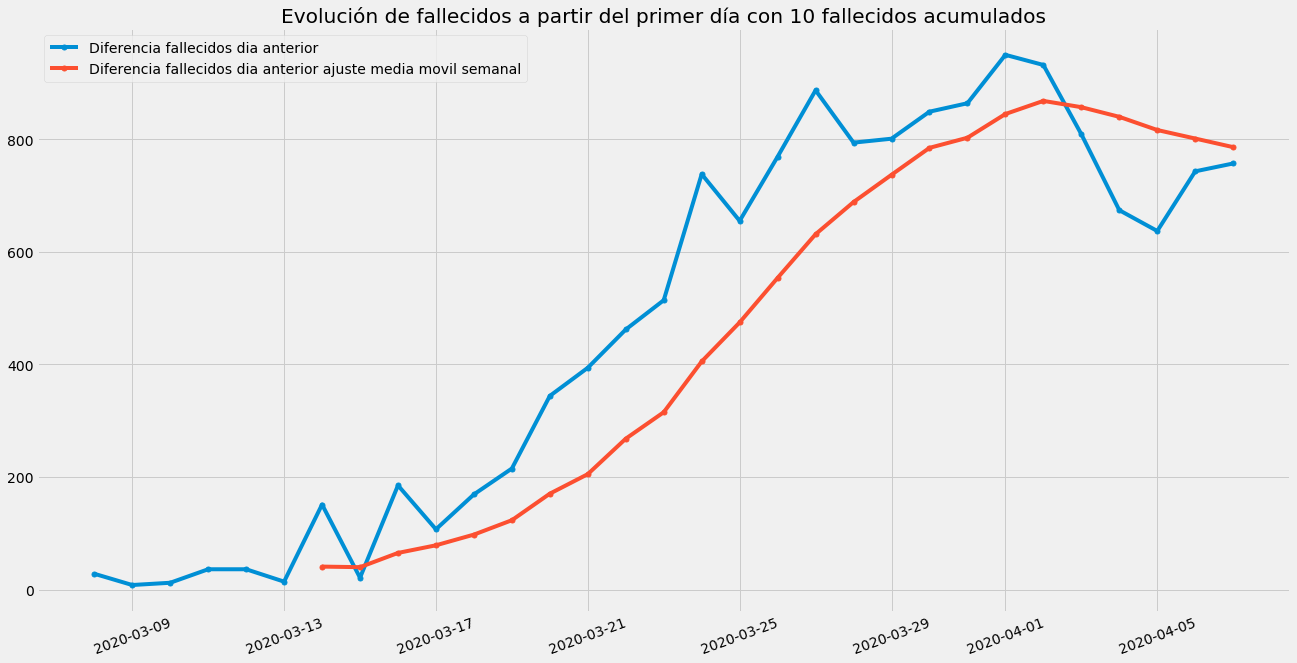

In [61]:
start, end = data_es.index.min(), data_es.index.max()
# Plot daily and weekly resampled time series together
fig, ax = plt.subplots(figsize=(20,10))
ax.plot(data_es.loc[start:end, 'Diferencia fallecidos dia anterior'],
marker='o', markersize=5, linestyle='-', label='Diferencia fallecidos dia anterior')
ax.plot(data_sem.loc[start:end, 'Diferencia fallecidos dia anterior'],
marker='o', markersize=5, linestyle='-', label='Diferencia fallecidos dia anterior ajuste media movil semanal')
plt.xticks(rotation=20)
plt.title("Evolución de fallecidos a partir del primer día con 10 fallecidos acumulados")
ax.legend();

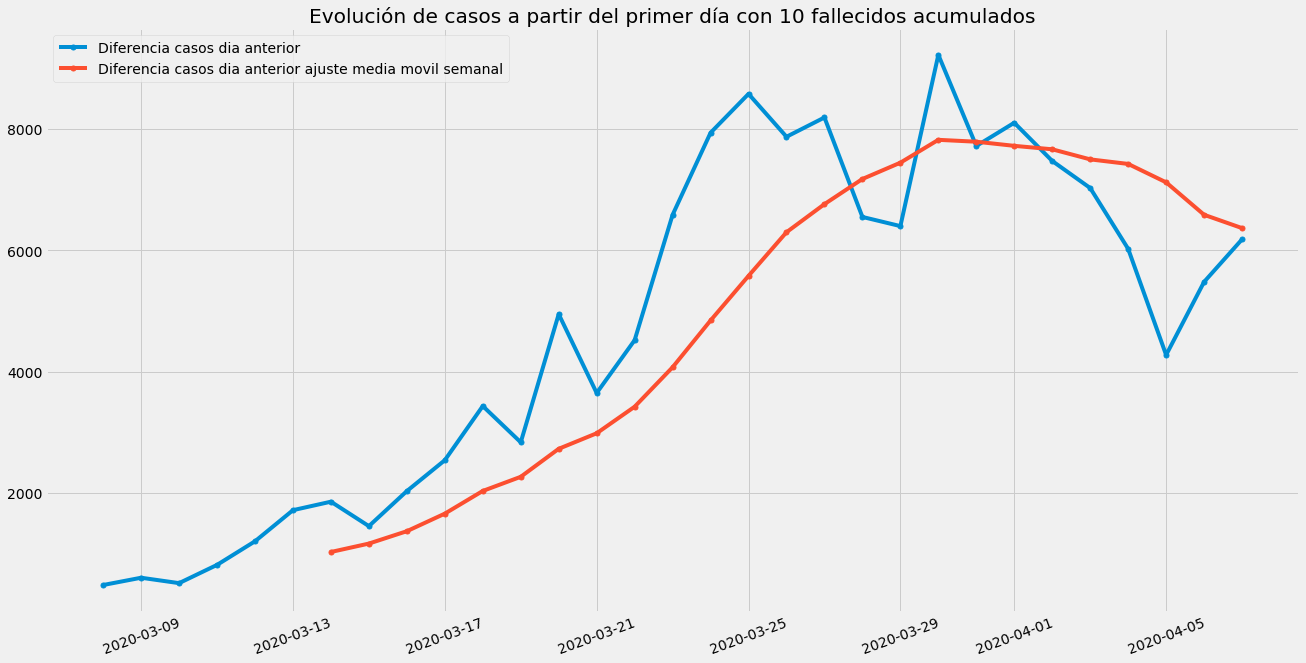

In [62]:
start, end = data_es.index.min(), data_es.index.max()
# Plot daily and weekly resampled time series together
fig, ax = plt.subplots(figsize=(20,10))
ax.plot(data_es.loc[start:end, 'Diferencia casos dia anterior'],
marker='o', markersize=5, linestyle='-', label='Diferencia casos dia anterior')
ax.plot(data_sem.loc[start:end, 'Diferencia casos dia anterior'],
marker='o', markersize=5, linestyle='-', label='Diferencia casos dia anterior ajuste media movil semanal')
plt.xticks(rotation=20)
plt.title("Evolución de casos a partir del primer día con 10 fallecidos acumulados")
ax.legend();

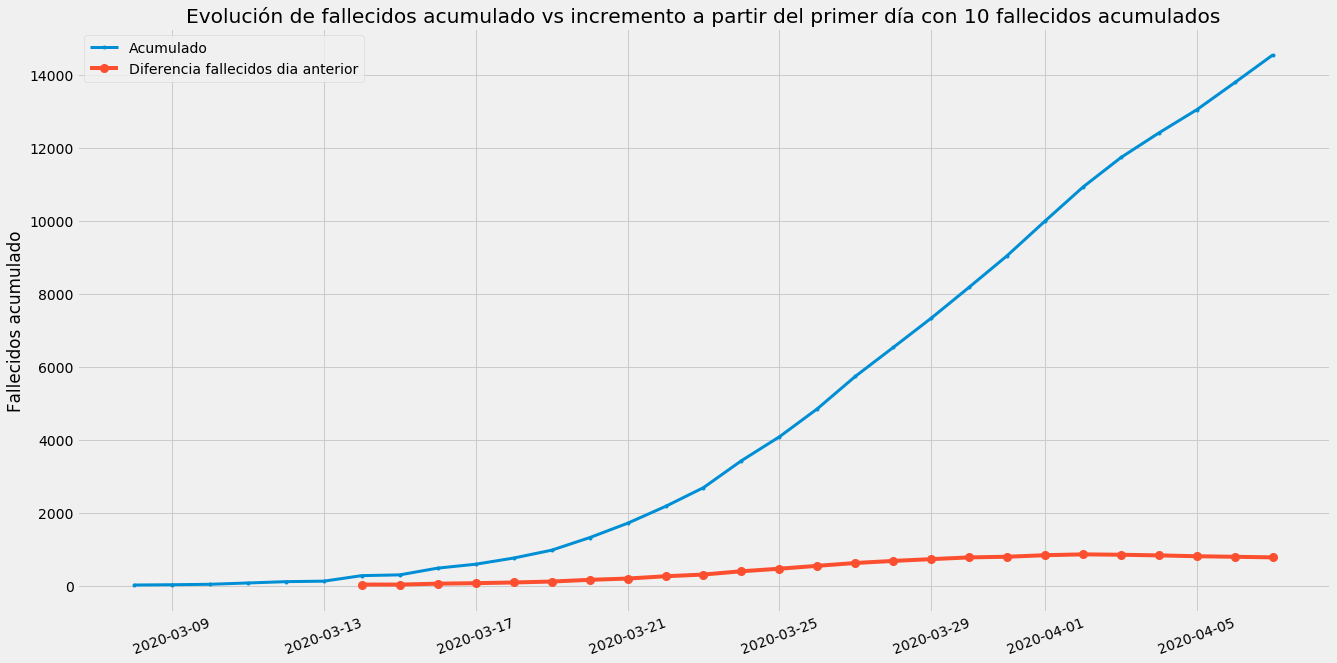

In [63]:
start, end = data_es.index.min(), data_es.index.max()
# Plot daily and weekly resampled time series together
fig, ax = plt.subplots(figsize=(20,10))
ax.plot(data_es.loc[start:end, 'Fallecidos'],
marker='.', linestyle='-', linewidth=3, label='Acumulado')
ax.plot(data_sem.loc[start:end, 'Diferencia fallecidos dia anterior'],
marker='o', markersize=8, linestyle='-', label='Diferencia fallecidos dia anterior')
ax.set_ylabel('Fallecidos acumulado')
plt.xticks(rotation=20)
plt.title("Evolución de fallecidos acumulado vs incremento a partir del primer día con 10 fallecidos acumulados")
ax.legend();

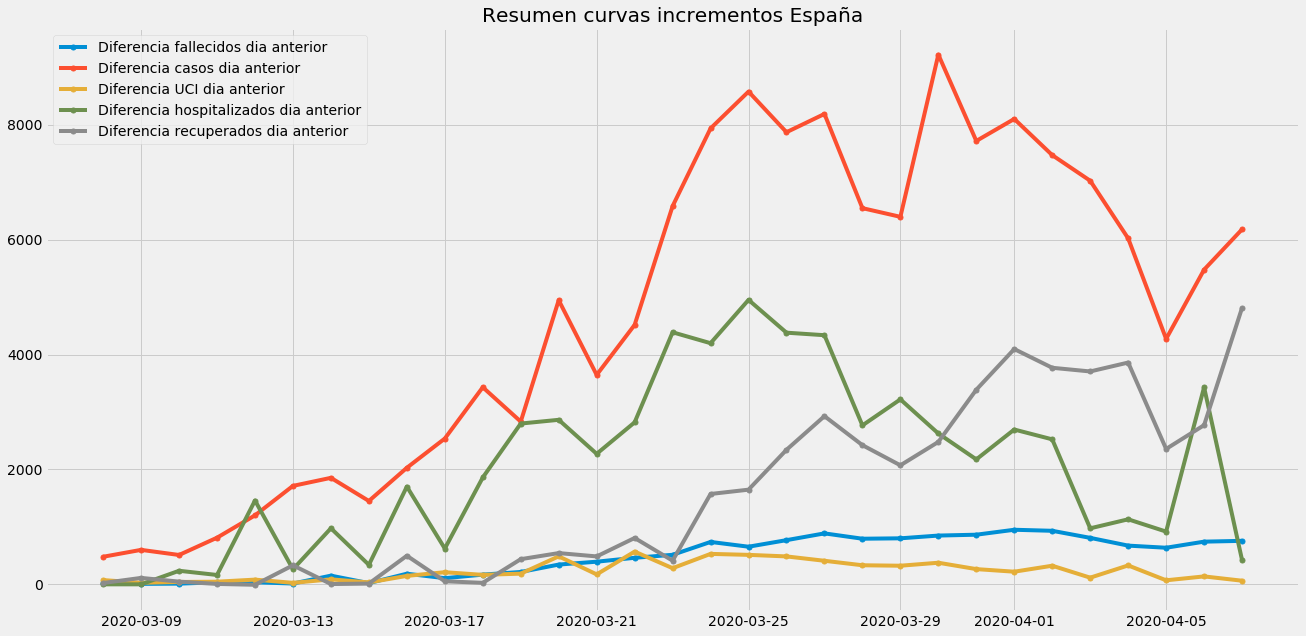

In [64]:
start, end = data_es.index.min(), data_es.index.max()
# Plot daily and weekly resampled time series together
fig, ax = plt.subplots(figsize=(20,10))
ax.plot(data_es.loc[start:end, 'Diferencia fallecidos dia anterior'],
marker='o', markersize=5, linestyle='-', label='Diferencia fallecidos dia anterior')
ax.plot(data_es.loc[start:end, 'Diferencia casos dia anterior'],
marker='o', markersize=5, linestyle='-', label='Diferencia casos dia anterior')
ax.plot(data_es.loc[start:end, 'Diferencia UCI dia anterior'],
marker='o', markersize=5, linestyle='-', label='Diferencia UCI dia anterior')
ax.plot(data_es.loc[start:end, 'Diferencia hospitalizados dia anterior'],
marker='o', markersize=5, linestyle='-', label='Diferencia hospitalizados dia anterior')
ax.plot(data_es.loc[start:end, 'Diferencia recuperados dia anterior'],
marker='o', markersize=5, linestyle='-', label='Diferencia recuperados dia anterior')
plt.title("Resumen curvas incrementos España");
ax.legend();

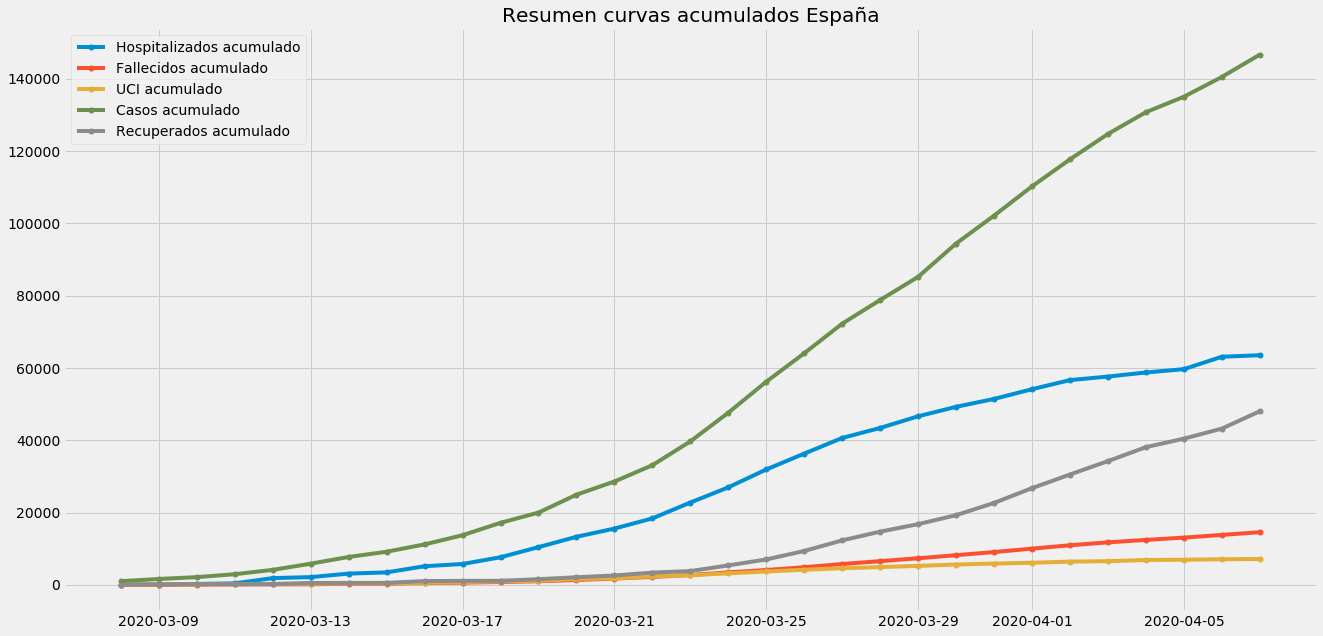

In [65]:
start, end = data_es.index.min(), data_es.index.max()
# Plot daily and weekly resampled time series together
fig, ax = plt.subplots(figsize=(20,10))

ax.plot(data_es.loc[start:end, 'Hospitalizados'],
marker='o', markersize=5, linestyle='-', label='Hospitalizados acumulado')
ax.plot(data_es.loc[start:end, 'Fallecidos'],
marker='o', markersize=5, linestyle='-', label='Fallecidos acumulado')
ax.plot(data_es.loc[start:end, 'UCI'],
marker='o', markersize=5, linestyle='-', label='UCI acumulado')
ax.plot(data_es.loc[start:end, 'Casos'],
marker='o', markersize=5, linestyle='-', label='Casos acumulado')
ax.plot(data_es.loc[start:end, 'Recuperados'],
marker='o', markersize=5, linestyle='-', label='Recuperados acumulado')
plt.title("Resumen curvas acumulados España");
ax.legend();

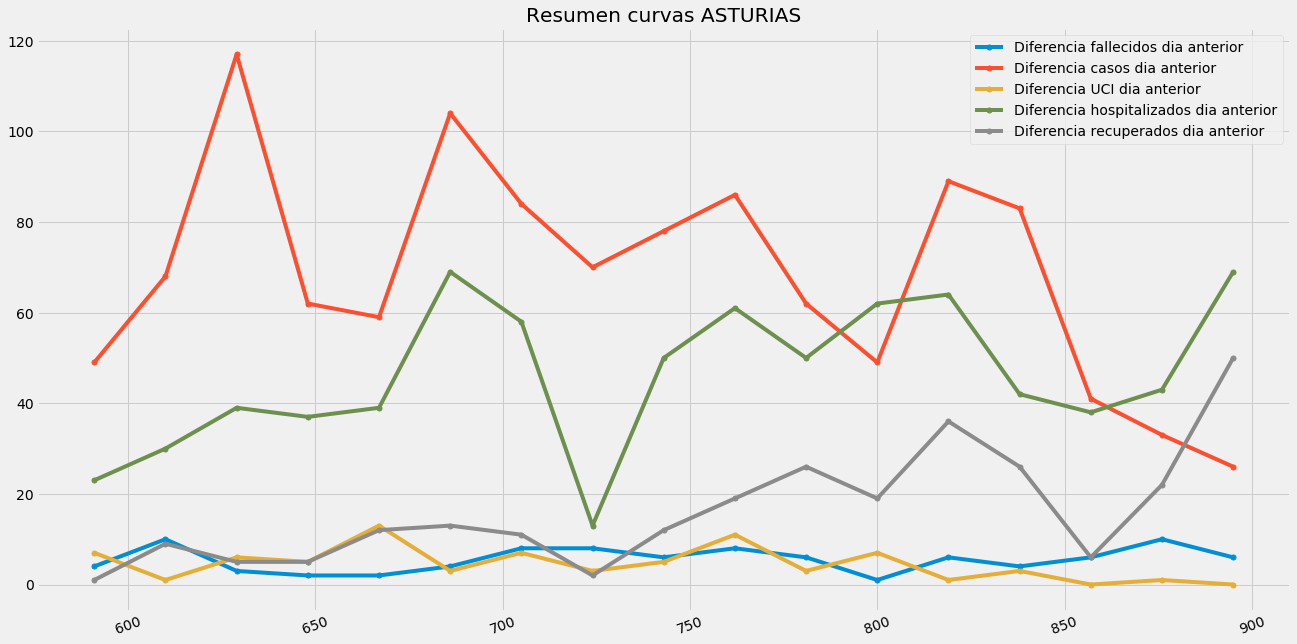

In [66]:
#Introducir código ISO de la comunidad a analizar (ejemplo Asturias) 
data = data[data["Fallecidos"] > 10]

start, end = data[data["CCAA Codigo ISO"] == "AS"].index.min(), data[data["CCAA Codigo ISO"] == "AS"].index.max()
fig, ax = plt.subplots(figsize=(20,10))
ax.plot(data[data["CCAA Codigo ISO"] == "AS"].loc[start:end, 'Diferencia fallecidos dia anterior'],
marker='o', markersize=5, linestyle='-', label='Diferencia fallecidos dia anterior')
ax.plot(data[data["CCAA Codigo ISO"] == "AS"].loc[start:end, 'Diferencia casos dia anterior'],
marker='o', markersize=5, linestyle='-', label='Diferencia casos dia anterior')
ax.plot(data[data["CCAA Codigo ISO"] == "AS"].loc[start:end, 'Diferencia UCI dia anterior'],
marker='o', markersize=5, linestyle='-', label='Diferencia UCI dia anterior')
ax.plot(data[data["CCAA Codigo ISO"] == "AS"].loc[start:end, 'Diferencia hospitalizados dia anterior'],
marker='o', markersize=5, linestyle='-', label='Diferencia hospitalizados dia anterior')
ax.plot(data[data["CCAA Codigo ISO"] == "AS"].loc[start:end, 'Diferencia recuperados dia anterior'],
marker='o', markersize=5, linestyle='-', label='Diferencia recuperados dia anterior')
ax.legend()
plt.xticks(rotation=20)
plt.title("Resumen curvas ASTURIAS");

In [50]:
data_sem_jh = data_sem_jh[data_sem_jh["Fallecidos"] > 10]
data_sem_jh = data_sem_jh.reset_index()
data_sem_jh = data_sem_jh.set_index('Fecha')


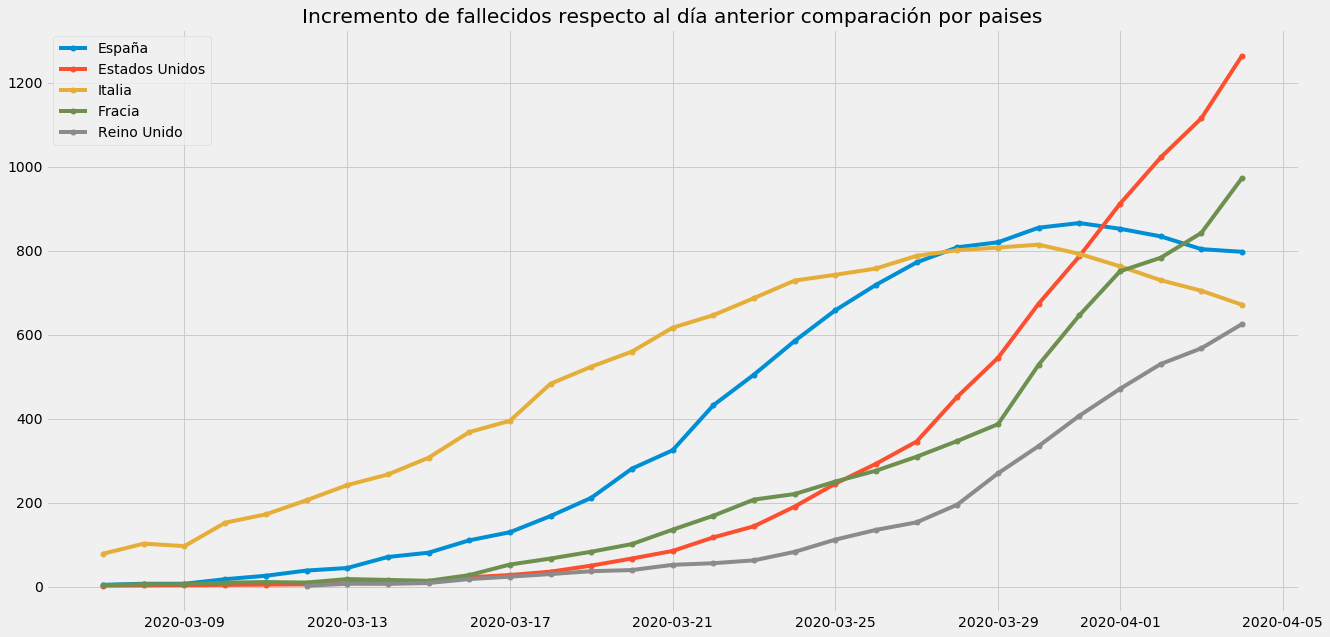

In [51]:
start, end = data_sem_jh[(data_sem_jh["Country/Region"] == "Spain") & (data_sem_jh["Fallecidos"] > 10)].index.min(), data_sem_jh[(data_sem_jh["Country/Region"] == "Spain") & (data_sem_jh["Fallecidos"] > 10)].index.max()
# Plot daily and weekly resampled time series together
fig, ax = plt.subplots(figsize=(20,10))
ax.plot(data_sem_jh[(data_sem_jh["Country/Region"] == "Spain") & (data_sem_jh["Fallecidos"] > 10)].loc[start:end, 'Diferencia fallecidos dia anterior'],
marker='o', markersize=5, linestyle='-', label='España')
ax.plot(data_sem_jh[(data_sem_jh["Country/Region"] == "US") & (data_sem_jh["Fallecidos"] > 10)].loc[start:end, 'Diferencia fallecidos dia anterior'],
marker='o', markersize=5, linestyle='-', label='Estados Unidos')
ax.plot(data_sem_jh[(data_sem_jh["Country/Region"] == "Italy") & (data_sem_jh["Fallecidos"] > 10)].loc[start:end, 'Diferencia fallecidos dia anterior'],
marker='o', markersize=5, linestyle='-', label='Italia')
ax.plot(data_sem_jh[(data_sem_jh["Country/Region"] == "France") & (data_sem_jh["Fallecidos"] > 10)].loc[start:end, 'Diferencia fallecidos dia anterior'],
marker='o', markersize=5, linestyle='-', label='Fracia')
ax.plot(data_sem_jh[(data_sem_jh["Country/Region"] == "United Kingdom") & (data_sem_jh["Fallecidos"] > 10)].loc[start:end, 'Diferencia fallecidos dia anterior'],
marker='o', markersize=5, linestyle='-', label='Reino Unido')
plt.title("Incremento de fallecidos respecto al día anterior comparación por paises");
ax.legend();

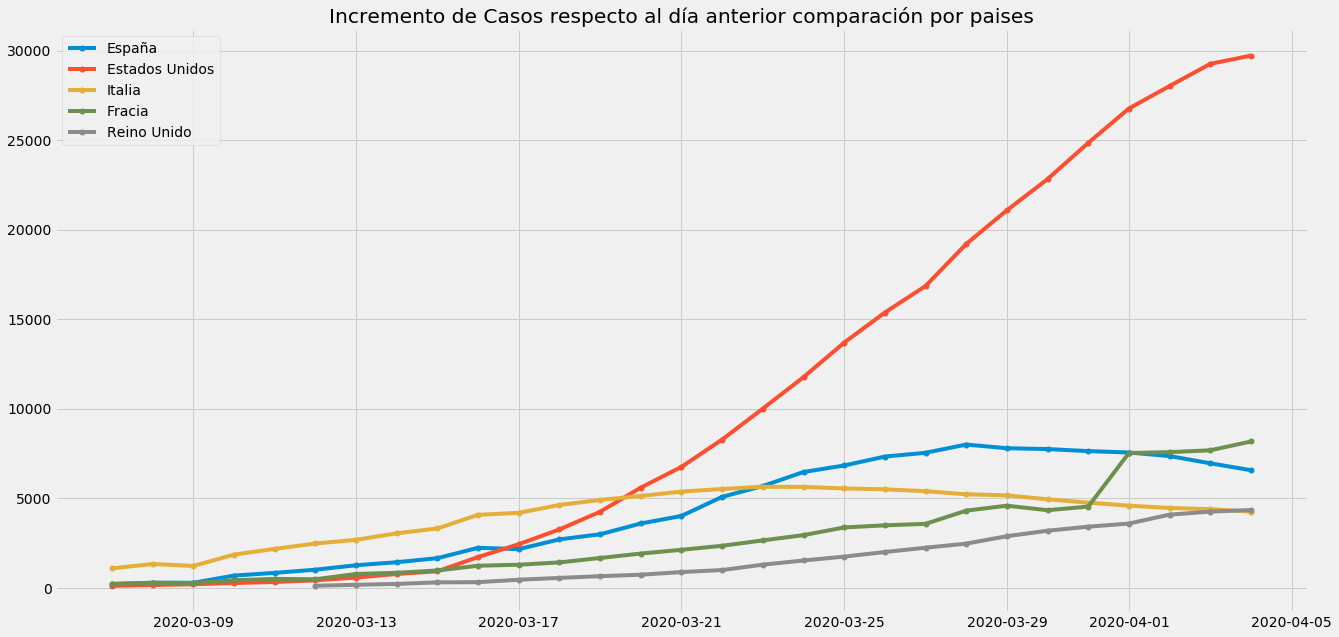

In [52]:
start, end = data_sem_jh[(data_sem_jh["Country/Region"] == "Spain") & (data_sem_jh["Fallecidos"] > 10)].index.min(), data_sem_jh[(data_sem_jh["Country/Region"] == "Spain") & (data_sem_jh["Fallecidos"] > 10)].index.max()
# Plot daily and weekly resampled time series together
fig, ax = plt.subplots(figsize=(20,10))
ax.plot(data_sem_jh[(data_sem_jh["Country/Region"] == "Spain") & (data_sem_jh["Casos"] > 10)].loc[start:end, 'Diferencia casos dia anterior'],
marker='o', markersize=5, linestyle='-', label='España')
ax.plot(data_sem_jh[(data_sem_jh["Country/Region"] == "US") & (data_sem_jh["Casos"] > 10)].loc[start:end, 'Diferencia casos dia anterior'],
marker='o', markersize=5, linestyle='-', label='Estados Unidos')
ax.plot(data_sem_jh[(data_sem_jh["Country/Region"] == "Italy") & (data_sem_jh["Casos"] > 10)].loc[start:end, 'Diferencia casos dia anterior'],
marker='o', markersize=5, linestyle='-', label='Italia')
ax.plot(data_sem_jh[(data_sem_jh["Country/Region"] == "France") & (data_sem_jh["Casos"] > 10)].loc[start:end, 'Diferencia casos dia anterior'],
marker='o', markersize=5, linestyle='-', label='Fracia')
ax.plot(data_sem_jh[(data_sem_jh["Country/Region"] == "United Kingdom") & (data_sem_jh["Casos"] > 10)].loc[start:end, 'Diferencia casos dia anterior'],
marker='o', markersize=5, linestyle='-', label='Reino Unido')
plt.title("Incremento de Casos respecto al día anterior comparación por paises");
ax.legend();

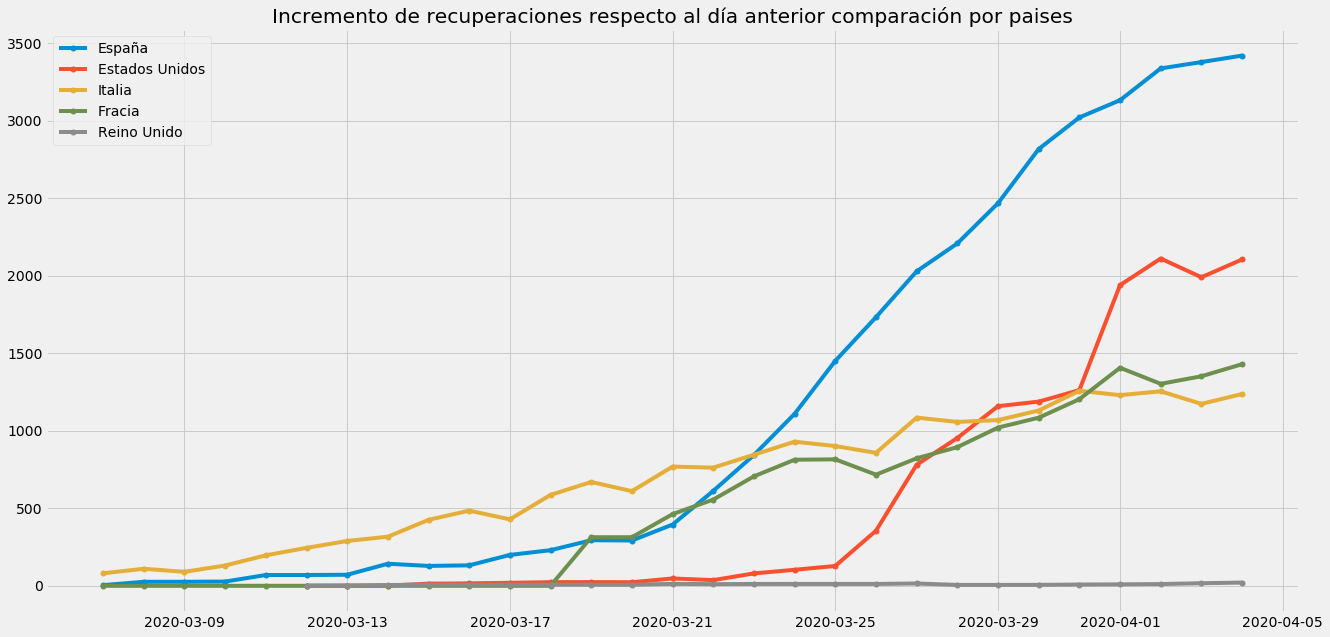

In [53]:
start, end = data_sem_jh[(data_sem_jh["Country/Region"] == "Spain") & (data_sem_jh["Recuperados"] > 10)].index.min(), data_sem_jh[(data_sem_jh["Country/Region"] == "Spain") & (data_sem_jh["Recuperados"] > 10)].index.max()
# Plot daily and weekly resampled time series together
fig, ax = plt.subplots(figsize=(20,10))
ax.plot(data_sem_jh[(data_sem_jh["Country/Region"] == "Spain") & (data_sem_jh["Recuperados"] > 10)].loc[start:end, 'Diferencia recuperados dia anterior'],
marker='o', markersize=5, linestyle='-', label='España')
ax.plot(data_sem_jh[(data_sem_jh["Country/Region"] == "US") & (data_sem_jh["Recuperados"] > 10)].loc[start:end, 'Diferencia recuperados dia anterior'],
marker='o', markersize=5, linestyle='-', label='Estados Unidos')
ax.plot(data_sem_jh[(data_sem_jh["Country/Region"] == "Italy") & (data_sem_jh["Recuperados"] > 10)].loc[start:end, 'Diferencia recuperados dia anterior'],
marker='o', markersize=5, linestyle='-', label='Italia')
ax.plot(data_sem_jh[(data_sem_jh["Country/Region"] == "France") & (data_sem_jh["Recuperados"] > 10)].loc[start:end, 'Diferencia recuperados dia anterior'],
marker='o', markersize=5, linestyle='-', label='Fracia')
ax.plot(data_sem_jh[(data_sem_jh["Country/Region"] == "United Kingdom") & (data_sem_jh["Recuperados"] > 10)].loc[start:end, 'Diferencia recuperados dia anterior'],
marker='o', markersize=5, linestyle='-', label='Reino Unido')
plt.title("Incremento de recuperaciones respecto al día anterior comparación por paises");
ax.legend();